In [1]:
import os
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import string
import re
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
import logging
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
from nltk import bigrams
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
from keras.layers import LSTM, GlobalMaxPooling1D
from keras.initializers import Constant
import keras.metrics
from numpy import newaxis
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn import metrics
from keras.layers import Conv1D
from keras.layers import MaxPooling1D, Flatten
from keras.optimizers import RMSprop
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras import losses
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


## Reading in the Data:

We have used all the tweets from 2018 (train and test) to create the embeddings. However, balanced datasets have been used to train and test the model. The following code reads in all the data. Note, we are only considering earthquakes and floods in the following sections and we will build separate models for each earthquakes and floods. 

In [2]:
os.chdir('../10_Data/30_Balanced Tweets (Crit = High = Medium = Low)/10_2018 Train')

In [3]:
df_e1 = pd.read_csv('earthquake_TREC_2018_train_BALANCED.csv')
df_f1 = pd.read_csv('flood_TREC_2018_train_BALANCED.csv')

In [4]:
os.chdir('../15_2018 Test')

In [5]:
df_e2 = pd.read_csv('earthquake_TREC_2018_test_BALANCED.csv')
df_f2 = pd.read_csv('flood_TREC_2018_test_BALANCED.csv')

In [6]:
os.chdir('../../20_Extracted Tweets/10_2018 Train')

In [7]:
df_e1_embed = pd.read_csv('Earthquake_TREC_2018_train.csv')
df_f1_embed = pd.read_csv('flood_TREC_2018_train.csv')

In [8]:
os.chdir('../15_2018 Test')

In [9]:
df_e2_embed = pd.read_csv('Earthquake_TREC_2018_test.csv')
df_f2_embed = pd.read_csv('Floods_TREC_2018_test.csv')

In [10]:
os.getcwd()

'C:\\Users\\Vishaal\\Documents\\GitHub\\TREC_Distributed_Machine_Learning\\TREC\\10_Data\\20_Extracted Tweets\\15_2018 Test'

## Combining dataframes
We are now combine earthquake tweets into one df and flood tweets into another df. We have subsetting on the tweets and priority columns. We do this for both the embedding dataframes and our balanced datasets, although we will not use the balanced datasets until later.

In [11]:
df_quake_e = pd.DataFrame()
df_quake_e['Tweet'] = pd.concat([df_e1_embed['Tweet'] , df_e2_embed['Tweet']])
df_quake_e['Priority'] = pd.concat([df_e1_embed['Priority'] , df_e2_embed['Priority']])

In [12]:
df_flood_e = pd.DataFrame()
df_flood_e['Tweet'] = pd.concat([df_f1_embed['Tweet'] , df_f2_embed['Tweet']])
df_flood_e['Priority'] = pd.concat([df_f1_embed['Priority'] , df_f2_embed['Priority']])

In [13]:
df_quake = pd.DataFrame()
df_quake['Tweet'] = pd.concat([df_e1['Tweet'] , df_e2['Tweet']])
df_quake['Priority'] = pd.concat([df_e1['Priority'] , df_e2['Priority']])

In [14]:
df_flood = pd.DataFrame()
df_flood['Tweet'] = pd.concat([df_f1['Tweet'] , df_f2['Tweet']])
df_flood['Priority'] = pd.concat([df_f1['Priority'] , df_f2['Priority']])

Cross checking the shapes to make sure they match. **They do match**

In [15]:
df_quake_e.shape, df_flood_e.shape, df_quake.shape, df_flood.shape

((5140, 2), (2518, 2), (100, 2), (120, 2))

## Converting to categorical (0 & 1)

We will now define a function to convert the priority to a categorical 0 & 1. This will be necessary when we train a model.

In [16]:
'''
Creating a categorical variable to keep label critical tweets as 1 and 0 otherwise
'''
def to_categorical(array):
    t = []
    for element in array:
        if element =='Critical':
            t.append(1)
        else:
            t.append(0)
        
    return (t)


## Pre-Processing

We shall now perform a series of pre processing to our tweets. This includes tokenizing them, removing stop words and lemmatising them.  

**I also wrote a line of code to remove the links in the tweets as it was throwing in a lot of gibberish into the emebddings.** The link is almost always at the end of the tweet so its relatively easy to remove. 

I left the punctuation marks in. We have to take a call on this later.

In [17]:
def preProcess(df):
    df['Tweet'] = df['Tweet'].astype('str')
    
    df['Tweet'] = df['Tweet'].apply(lambda x: re.split('https?://\S+', str(x))[0])
    
    token_array = []
    #for tweet in df['Tweet']:
    #    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    #    tweet = tweet.translate(translator)
    #    token_tweet = word_tokenize(tweet)
    #    token_array.append(token_tweet)
    
    for tweet in df['Tweet']:
        token_tweet = word_tokenize(tweet)
        token_array.append(token_tweet)
        
    stop_words=set(stopwords.words("english"))
    filtered_token_array=[]
    for tweet in token_array:
        filtered_tweet = []
        for word in tweet:
                if word not in stop_words:
                    filtered_tweet.append(word)
        filtered_token_array.append(filtered_tweet)
        
    lem = WordNetLemmatizer()

    lemmatized_array=[]
    for tweet in filtered_token_array:
        lemmatized_tweet = []
        for word in tweet:
            lemmatized_tweet.append(lem.lemmatize(word,'v'))
        lemmatized_array.append(lemmatized_tweet)
    
    lemmatized_array_join = []
    for element in lemmatized_array:
        lemmatized_array_join.append(' '.join(element))
        
    return (lemmatized_array_join)


The tweets have been pre processed and we now have a collection of tweets. Word2Vec takes in a list of words together contained in a bigger list (Corpus -> List of Tweet -> List of Words).

In [18]:
l_quake_e = preProcess(df_quake_e)
l_flood_e = preProcess(df_flood_e)

list_of_words_quake = []
list_of_words_flood = []

for tweet in l_quake_e:
        token_tweet = word_tokenize(tweet)
        list_of_words_quake.append(token_tweet)
        
for tweet in l_flood_e:
        token_tweet = word_tokenize(tweet)
        list_of_words_flood.append(token_tweet)
        

In [19]:
l_quake_e

['ã€� # USGS # Breakingã€ ‘ M 1.1 , 28km SSW Fairbanks , Alaska',
 '# Earthquake M 4.8 , south Bali , Indonesia : September 04 , 2012 21:19:30 GMT',
 '# earthquake : M 4.5 , Taiwan region',
 '# earthquake M 2.6 , Hawaii region , Hawaii',
 'Magnitude 7.9 earthquake strike coast Costa Rica - USGS',
 'RT @ Reuters : Live coverage : 7.9-magnitude earthquake rattle coast Costa Rica ; tsunami watch Caribbean effect -',
 'ãƒ‡ã‚ « ã‚¤ã�ªã€‚ã�§ã�‹ã�™ã�Žã‚‹ã�œã€�ãƒ™ã‚¯ãƒ†ãƒ « ï¼�',
 'RT @ BreakingNews : Magnitude 7.9 earthquake strike coast Costa Rica - USGS',
 'RT @ BreakingNews : Caribbean-wide tsunami watch effect Costa Rican quake , Pacific Tsunami Warning Center say - @ Reuters # lgf # p2',
 'Costa Rican shake magnitude-5.8 earthquake',
 'RT @ Reuters : More : 7.9-magnitude earthquake rattle coastline Costa Rica , USGS say -',
 'RT @ AlertNet : Strong earthquake hit Costa Rica',
 'RT @ BreakingNews : Caribbean-wide tsunami watch effect Costa Rican quake , Pacific Tsunami Warning Center say 

## Creating a Word2Vec model

We will now initialise a word2vec model. This takes in a paramter 'min_count' which is the number of minimum occurences of a word required for it be included in the embeddings. **For now we set min_count = 1**. I did this because we are creating our own embeddings (not picking from wikipedia embeddings etc) and our data is not that huge. 

In [20]:
'''
min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)

window = int - The maximum distance between the current and predicted word within a sentence. 
        E.g. window words on the left and window words on the left of our target - (2, 10)

size = int - Dimensionality of the feature vectors. - (50, 300)

sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. 
        Highly influencial. - (0, 1e-5)

alpha = float - The initial learning rate - (0.01, 0.05)

min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. 
        To set it: alpha - (min_alpha * epochs) ~ 0.00

negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" 
        should be drown. If set to 0, no negative sampling is used. - (5, 20)
        
workers = int - Use these many worker threads to train the model (=faster training with multicore machines)
'''
w2v_quake = Word2Vec(min_count=1,
                     window=4,
                     size=100,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20)
w2v_flood = Word2Vec(min_count=1,
                     window=4,
                     size=100,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20)

We will now build our vocabulary. Do not run the following code multiple times before initialising the w2v instance again from above.

In [21]:
w2v_quake.build_vocab(list_of_words_quake)
w2v_flood.build_vocab(list_of_words_flood)

INFO - 11:04:05: collecting all words and their counts
INFO - 11:04:05: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 11:04:05: collected 11096 word types from a corpus of 61160 raw words and 5140 sentences
INFO - 11:04:05: Loading a fresh vocabulary
INFO - 11:04:05: effective_min_count=1 retains 11096 unique words (100% of original 11096, drops 0)
INFO - 11:04:05: effective_min_count=1 leaves 61160 word corpus (100% of original 61160, drops 0)
INFO - 11:04:05: deleting the raw counts dictionary of 11096 items
INFO - 11:04:05: sample=6e-05 downsamples 771 most-common words
INFO - 11:04:05: downsampling leaves estimated 29232 word corpus (47.8% of prior 61160)
INFO - 11:04:05: estimated required memory for 11096 words and 100 dimensions: 14424800 bytes
INFO - 11:04:05: resetting layer weights
INFO - 11:04:07: collecting all words and their counts
INFO - 11:04:07: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 11:04:07: collected 8278 

The following code is to view the vocabulary that we created

In [22]:
vocabulary_quake = w2v_quake.wv.vocab
vocabulary_flood = w2v_flood.wv.vocab
vocabulary_quake

{'ã€�': <gensim.models.keyedvectors.Vocab at 0x1d1d1ba9c18>,
 '#': <gensim.models.keyedvectors.Vocab at 0x1d1d1bb83c8>,
 'USGS': <gensim.models.keyedvectors.Vocab at 0x1d1d1bb80b8>,
 'Breakingã€': <gensim.models.keyedvectors.Vocab at 0x1d1d1bb8b38>,
 '‘': <gensim.models.keyedvectors.Vocab at 0x1d1d1bb84a8>,
 'M': <gensim.models.keyedvectors.Vocab at 0x1d1d1bb8438>,
 '1.1': <gensim.models.keyedvectors.Vocab at 0x1d1d1bb8518>,
 ',': <gensim.models.keyedvectors.Vocab at 0x1d1d1bb8550>,
 '28km': <gensim.models.keyedvectors.Vocab at 0x1d1d1bb8588>,
 'SSW': <gensim.models.keyedvectors.Vocab at 0x1d1d1bb85c0>,
 'Fairbanks': <gensim.models.keyedvectors.Vocab at 0x1d1d1bb85f8>,
 'Alaska': <gensim.models.keyedvectors.Vocab at 0x1d1d1bb8630>,
 'Earthquake': <gensim.models.keyedvectors.Vocab at 0x1d1d1bb8668>,
 '4.8': <gensim.models.keyedvectors.Vocab at 0x1d1d1bb86a0>,
 'south': <gensim.models.keyedvectors.Vocab at 0x1d1d1bb86d8>,
 'Bali': <gensim.models.keyedvectors.Vocab at 0x1d1d1bb8710>,
 'In

In [23]:
w2v_quake.train(list_of_words_quake, total_examples=w2v_quake.corpus_count, epochs=30, report_delay=1)
w2v_flood.train(list_of_words_flood, total_examples=w2v_quake.corpus_count, epochs=30, report_delay=1)

INFO - 11:04:08: training model with 3 workers on 11096 vocabulary and 100 features, using sg=0 hs=0 sample=6e-05 negative=20 window=4
INFO - 11:04:08: worker thread finished; awaiting finish of 2 more threads
INFO - 11:04:09: worker thread finished; awaiting finish of 1 more threads
INFO - 11:04:09: worker thread finished; awaiting finish of 0 more threads
INFO - 11:04:09: EPOCH - 1 : training on 61160 raw words (29253 effective words) took 0.1s, 434421 effective words/s
INFO - 11:04:09: worker thread finished; awaiting finish of 2 more threads
INFO - 11:04:09: worker thread finished; awaiting finish of 1 more threads
INFO - 11:04:09: worker thread finished; awaiting finish of 0 more threads
INFO - 11:04:09: EPOCH - 2 : training on 61160 raw words (29337 effective words) took 0.1s, 318410 effective words/s
INFO - 11:04:09: worker thread finished; awaiting finish of 2 more threads
INFO - 11:04:09: worker thread finished; awaiting finish of 1 more threads
INFO - 11:04:09: worker thread 

INFO - 11:04:10: EPOCH - 24 : training on 61160 raw words (29155 effective words) took 0.1s, 314809 effective words/s
INFO - 11:04:11: worker thread finished; awaiting finish of 2 more threads
INFO - 11:04:11: worker thread finished; awaiting finish of 1 more threads
INFO - 11:04:11: worker thread finished; awaiting finish of 0 more threads
INFO - 11:04:11: EPOCH - 25 : training on 61160 raw words (29102 effective words) took 0.1s, 338312 effective words/s
INFO - 11:04:11: worker thread finished; awaiting finish of 2 more threads
INFO - 11:04:11: worker thread finished; awaiting finish of 1 more threads
INFO - 11:04:11: worker thread finished; awaiting finish of 0 more threads
INFO - 11:04:11: EPOCH - 26 : training on 61160 raw words (29367 effective words) took 0.1s, 355565 effective words/s
INFO - 11:04:11: worker thread finished; awaiting finish of 2 more threads
INFO - 11:04:11: worker thread finished; awaiting finish of 1 more threads
INFO - 11:04:11: worker thread finished; await

INFO - 11:04:12: worker thread finished; awaiting finish of 1 more threads
INFO - 11:04:12: worker thread finished; awaiting finish of 0 more threads
INFO - 11:04:12: EPOCH - 14 : training on 43018 raw words (19850 effective words) took 0.1s, 350950 effective words/s
WARNING - 11:04:12: EPOCH - 14 : supplied example count (2518) did not equal expected count (5140)
INFO - 11:04:12: worker thread finished; awaiting finish of 2 more threads
INFO - 11:04:12: worker thread finished; awaiting finish of 1 more threads
INFO - 11:04:12: worker thread finished; awaiting finish of 0 more threads
INFO - 11:04:12: EPOCH - 15 : training on 43018 raw words (19913 effective words) took 0.1s, 394590 effective words/s
WARNING - 11:04:12: EPOCH - 15 : supplied example count (2518) did not equal expected count (5140)
INFO - 11:04:12: worker thread finished; awaiting finish of 2 more threads
INFO - 11:04:12: worker thread finished; awaiting finish of 1 more threads
INFO - 11:04:12: worker thread finished; 

(598841, 1290540)

The following code allows us to see words closely related (positively or negatively) with any other word. In this case we put in the word 'help'.

In [24]:
w2v_quake.wv.most_similar(positive=["dead"])

INFO - 11:04:13: precomputing L2-norms of word weight vectors


[('rock', 0.999570369720459),
 ('7.4-magnitude', 0.999549388885498),
 ('least', 0.999498724937439),
 ('Powerful', 0.9994916915893555),
 ('Reuters', 0.9994686841964722),
 ('A', 0.9994640350341797),
 ('northern', 0.9994277954101562),
 ('Italy', 0.9994176626205444),
 ('powerful', 0.9993869662284851),
 ('kill', 0.9993749856948853)]

We will now convert these word2vec embeddings into a pandas dataframe. This can be converted into a csv for use later in maybe R. We will also explore ways to use this in an SVM model to classify our tweets. 

In [25]:
word_list_quake = []
vector_list_quake = []
for word in w2v_quake.wv.vocab:
    word_list_quake.append(word)
    vector_list_quake.append(w2v_quake.wv.get_vector(word))
    
word_list_flood = []
vector_list_flood = []
for word in w2v_flood.wv.vocab:
    word_list_flood.append(word)
    vector_list_flood.append(w2v_flood.wv.get_vector(word))

In [26]:
quake_embeddings = pd.DataFrame()
quake_embeddings['Word'] = word_list_quake
quake_embeddings['Vector'] = vector_list_quake

In [27]:
flood_embeddings = pd.DataFrame()
flood_embeddings['Word'] = (word_list_flood)
flood_embeddings['Vector'] = (vector_list_flood)

In [28]:
quake_embeddings.to_csv('Word2Vec_Earthquake.csv')
flood_embeddings.to_csv('Word2Vec_Flood.csv')

I take the emebddings and create an emebedding index in the {word :  embedding} format.

In [27]:
quake_embeddings_index = {}
for word, value in zip(word_list_quake, vector_list_quake):
    quake_embeddings_index[word] = value
    
print ('Found %s words for quakes' %len(quake_embeddings_index))

flood_embeddings_index = {}    
for word, value in zip(word_list_flood, vector_list_flood):
     flood_embeddings_index[word] = value

print ('Found %s words for floods' %len(flood_embeddings_index))


Found 11096 words for quakes
Found 8278 words for floods


Checking if the number of words match with the number of words we had for quakes

In [28]:
quake_embeddings.shape

(11096, 2)

Keras tokenizer method is very useful. It takes a list of text and the 'fit_on_texts' method updates the vocalbulary and assigns a number to each word. The 'texts_to_sequences' method creates a vector of these words from the indices created. This is the format the algorithm understands for NLP applications. Now that we ahve the embeddings ready, we will go ahead and try these on our balanced daatsets. The embeddings are no good if we can use them to feature engineer our data and fit a model to it.

In [29]:
tokenizer_quake = Tokenizer()
tokenizer_quake.fit_on_texts(df_quake['Tweet'])
sequences_quake = tokenizer_quake.texts_to_sequences(df_quake['Tweet'])

word_index_quake = tokenizer_quake.word_index
print('Number of unique tokens for quakes = ', len(word_index_quake))

tokenizer_flood = Tokenizer()
tokenizer_flood.fit_on_texts(df_flood['Tweet'])
sequences_flood = tokenizer_flood.texts_to_sequences(df_flood['Tweet'])

word_index_flood = tokenizer_flood.word_index
print('Number of unique tokens for floods = ', len(word_index_flood))

Number of unique tokens for quakes =  785
Number of unique tokens for floods =  974


We will proceed and make all the vectors equal length by padding them with zeros in the end. 

In [30]:
quake_padded = pad_sequences(sequences_quake)
flood_padded = pad_sequences(sequences_flood)

## RNN LSTM Classifier

### Creating Word2Vec Vectors for Train Data:

Before we can implement the classifier, we need to convert our sentences (from balanced df) to a word2vec representation using our word2vec model that we trained above. This was tricky. All vectors corresponding to the tweets have to be the same length as the longest one. However, this does not mean we simply pad a 0 to the end of all the tweets but we need to append an array size (100,) beacuse each word in our word2vec is in 100 dimensions.

In [31]:
'''
    Function to convert to padded word indices
'''
def convert_to_vec(tweets):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(tweets)
    sequences = tokenizer.texts_to_sequences(tweets)

    word_index = tokenizer.word_index
    padded = pad_sequences(sequences,  padding = 'post')
    
    return (padded, word_index)

In [32]:
'''
    Function to create and emebdding matrix - Use our pre-trained embeddings alongside our vectorised tweets data from the 
    balanced datasets
'''
def word2vec(word_index, embedding_index, embedding_dim = 100):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return(embedding_matrix)

Breaking the quake df into 3 different dfs. Each df with have equal number of (citical, high), (critical, med) and (critical, low} tweets. We will analyse how the model does w.r.t to each of these categories. We are then getting the respective embeddings for each df. The embeddings will be in the shape of (50, 34, 100) aka (50 tweets, max padded length 34 and 100 dims)

In [33]:
'''
    Earthquakes
'''
df_quake_low = df_quake[(df_quake['Priority'] == 'Critical') | (df_quake['Priority'] == 'Low')]
df_quake_med = df_quake[(df_quake['Priority'] == 'Critical') | (df_quake['Priority'] == 'Medium')]
df_quake_high = df_quake[(df_quake['Priority'] == 'Critical') | (df_quake['Priority'] == 'High')]

l_quake_l = preProcess(df_quake_low)
vec_convert_quake_l, quake_l_index = convert_to_vec(l_quake_l)
word2vec_convert_quake_l = word2vec(word_index = quake_l_index, embedding_index = quake_embeddings_index)


l_quake_m = preProcess(df_quake_med)
vec_convert_quake_m, quake_m_index = convert_to_vec(l_quake_m)
word2vec_convert_quake_m = word2vec(word_index = quake_m_index, embedding_index = quake_embeddings_index)

l_quake_h = preProcess(df_quake_high)
vec_convert_quake_h, quake_h_index = convert_to_vec(l_quake_h)
word2vec_convert_quake_h = word2vec(word_index = quake_h_index, embedding_index = quake_embeddings_index)


t_quake_low = to_categorical(df_quake_low['Priority'])
t_quake_med = to_categorical(df_quake_med['Priority'])
t_quake_high = to_categorical(df_quake_high['Priority'])

vec_convert_quake_l, t_quake_low = shuffle(vec_convert_quake_l, t_quake_low)
vec_convert_quake_m, t_quake_med = shuffle(vec_convert_quake_m, t_quake_med)
vec_convert_quake_h, t_quake_high = shuffle(vec_convert_quake_h, t_quake_high)


C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [34]:
'''
    Floods
'''
df_flood_low = df_flood[(df_flood['Priority'] == 'Critical') | (df_flood['Priority'] == 'Low')]
df_flood_med = df_flood[(df_flood['Priority'] == 'Critical') | (df_flood['Priority'] == 'Medium')]
df_flood_high = df_flood[(df_flood['Priority'] == 'Critical') | (df_flood['Priority'] == 'High')]

#One tweet does not want to work. Returns empty array. Will return to this later
#df_flood_low = df_flood_low.drop([87])

l_flood_l = preProcess(df_flood_low)
vec_convert_flood_l, flood_l_index = convert_to_vec(l_flood_l)
word2vec_convert_flood_l = word2vec(word_index = flood_l_index, embedding_index = flood_embeddings_index)


l_flood_m = preProcess(df_flood_med)
vec_convert_flood_m, flood_m_index = convert_to_vec(l_flood_m)
word2vec_convert_flood_m = word2vec(word_index = flood_m_index, embedding_index = flood_embeddings_index)

l_flood_h = preProcess(df_flood_high)
vec_convert_flood_h, flood_h_index = convert_to_vec(l_flood_h)
word2vec_convert_flood_h = word2vec(word_index = flood_h_index, embedding_index = flood_embeddings_index)


t_flood_low = to_categorical(df_flood_low['Priority'])
t_flood_med = to_categorical(df_flood_med['Priority'])
t_flood_high = to_categorical(df_flood_high['Priority'])

vec_convert_flood_l, t_flood_low = shuffle(vec_convert_flood_l, t_flood_low)
vec_convert_flood_m, t_flood_med = shuffle(vec_convert_flood_m, t_flood_med)
vec_convert_flood_h, t_flood_high = shuffle(vec_convert_flood_h, t_flood_high)


C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## Define an Embedding Layer

Using the emebdding amtrix above, we shall define an emebdding layer. This layer will then be incorporated into the keras model. Note how the 'trainable' has been set to False to prevent this part of the network from being trained. We will use the weights from the pre trained word2vec emebddings we trained previously. 

In [2480]:
model = keras.Sequential()    
model.add(Embedding(len(flood_h_index) + 1,
                            weights=[word2vec_convert_flood_h],
                            input_shape = (vec_convert_flood_h.shape[1], ),
                            output_dim = 100,
                            trainable=False))
model.add(Conv1D(16, 3, activation = 'relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(8, 3, activation = 'relu'))
model.add(MaxPooling1D(3))
model.add(Flatten())
#model.add(LSTM(8, input_shape = (vec_convert_flood_h.shape[1], 100), return_sequences = True))
#model.add(LSTM(4, return_sequences = False))
model.add(Dense(1,activation='sigmoid'))

In [2481]:
model.compile(optimizer=RMSprop(learning_rate = 0.01),
                  loss='binary_crossentropy',
                  metrics=['acc', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC()])

In [2482]:
history = model.fit( vec_convert_flood_h, t_flood_high , batch_size=2, epochs=200, validation_split=0.3, shuffle=True)

Train on 42 samples, validate on 18 samples
Epoch 1/200
42/42 [==============================] - 1s 19ms/step - loss: 0.7978 - acc: 0.5000 - precision_228: 0.4444 - recall_228: 0.4211 - auc_228: 0.4954 - val_loss: 0.6646 - val_acc: 0.6111 - val_precision_228: 0.6250 - val_recall_228: 0.9091 - val_auc_228: 0.7143
Epoch 2/200
42/42 [==============================] - 0s 2ms/step - loss: 0.7218 - acc: 0.5238 - precision_228: 0.4783 - recall_228: 0.5789 - auc_228: 0.4691 - val_loss: 0.7005 - val_acc: 0.3889 - val_precision_228: 0.0000e+00 - val_recall_228: 0.0000e+00 - val_auc_228: 0.7468
Epoch 3/200
42/42 [==============================] - 0s 2ms/step - loss: 0.7008 - acc: 0.5476 - precision_228: 0.0000e+00 - recall_228: 0.0000e+00 - auc_228: 0.4416 - val_loss: 0.6968 - val_acc: 0.3889 - val_precision_228: 0.0000e+00 - val_recall_228: 0.0000e+00 - val_auc_228: 0.7468
Epoch 4/200
42/42 [==============================] - 0s 2ms/step - loss: 0.6968 - acc: 0.5000 - precision_228: 0.2500 - reca

42/42 [==============================] - 0s 2ms/step - loss: 0.5050 - acc: 0.7143 - precision_228: 0.7059 - recall_228: 0.6316 - auc_228: 0.8341 - val_loss: 1.4892 - val_acc: 0.4444 - val_precision_228: 0.6667 - val_recall_228: 0.1818 - val_auc_228: 0.4026
Epoch 62/200
42/42 [==============================] - 0s 2ms/step - loss: 0.5223 - acc: 0.7381 - precision_228: 0.7222 - recall_228: 0.6842 - auc_228: 0.8227 - val_loss: 1.3864 - val_acc: 0.3333 - val_precision_228: 0.4000 - val_recall_228: 0.1818 - val_auc_228: 0.4221
Epoch 63/200
42/42 [==============================] - 0s 2ms/step - loss: 0.4787 - acc: 0.7381 - precision_228: 0.7000 - recall_228: 0.7368 - auc_228: 0.8501 - val_loss: 1.5522 - val_acc: 0.4444 - val_precision_228: 0.6667 - val_recall_228: 0.1818 - val_auc_228: 0.4286
Epoch 64/200
42/42 [==============================] - 0s 2ms/step - loss: 0.5376 - acc: 0.6667 - precision_228: 0.6667 - recall_228: 0.5263 - auc_228: 0.7941 - val_loss: 1.5065 - val_acc: 0.3889 - val_pr

42/42 [==============================] - 0s 2ms/step - loss: 0.4984 - acc: 0.7619 - precision_228: 0.7143 - recall_228: 0.7895 - auc_228: 0.8478 - val_loss: 1.4826 - val_acc: 0.3333 - val_precision_228: 0.4000 - val_recall_228: 0.1818 - val_auc_228: 0.3896
Epoch 92/200
42/42 [==============================] - 0s 2ms/step - loss: 0.4583 - acc: 0.8333 - precision_228: 0.8333 - recall_228: 0.7895 - auc_228: 0.8581 - val_loss: 1.3197 - val_acc: 0.4444 - val_precision_228: 0.6667 - val_recall_228: 0.1818 - val_auc_228: 0.5260
Epoch 93/200
42/42 [==============================] - 0s 2ms/step - loss: 0.4283 - acc: 0.8095 - precision_228: 0.7895 - recall_228: 0.7895 - auc_228: 0.8787 - val_loss: 1.6137 - val_acc: 0.5000 - val_precision_228: 0.7500 - val_recall_228: 0.2727 - val_auc_228: 0.4481
Epoch 94/200
42/42 [==============================] - 0s 2ms/step - loss: 0.4978 - acc: 0.7619 - precision_228: 0.7368 - recall_228: 0.7368 - auc_228: 0.8593 - val_loss: 1.7244 - val_acc: 0.3889 - val_pr

42/42 [==============================] - 0s 2ms/step - loss: 0.4515 - acc: 0.8333 - precision_228: 0.8000 - recall_228: 0.8421 - auc_228: 0.8741 - val_loss: 2.0770 - val_acc: 0.3333 - val_precision_228: 0.3333 - val_recall_228: 0.0909 - val_auc_228: 0.3312
Epoch 152/200
42/42 [==============================] - 0s 3ms/step - loss: 0.3687 - acc: 0.7857 - precision_228: 0.8125 - recall_228: 0.6842 - auc_228: 0.9062 - val_loss: 2.0221 - val_acc: 0.3333 - val_precision_228: 0.4000 - val_recall_228: 0.1818 - val_auc_228: 0.3377
Epoch 153/200
42/42 [==============================] - 0s 2ms/step - loss: 0.4050 - acc: 0.7619 - precision_228: 0.7143 - recall_228: 0.7895 - auc_228: 0.8844 - val_loss: 1.6576 - val_acc: 0.3889 - val_precision_228: 0.5000 - val_recall_228: 0.2727 - val_auc_228: 0.4416
Epoch 154/200
42/42 [==============================] - 0s 2ms/step - loss: 0.4097 - acc: 0.7381 - precision_228: 0.7222 - recall_228: 0.6842 - auc_228: 0.8833 - val_loss: 1.9120 - val_acc: 0.3333 - val

In [2429]:
y_pred = model.predict(history.validation_data[0])

In [2479]:
history.validation_data[1]

array([[0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1]])

In [2430]:
y_pred

array([[0.362435  ],
       [0.08394768],
       [0.9871652 ],
       [0.18175653],
       [0.68670803],
       [0.45487538],
       [0.84244996],
       [0.9890148 ],
       [0.9635279 ],
       [0.35595906],
       [0.941171  ],
       [0.11157177],
       [0.20823424],
       [0.5498065 ],
       [0.04340995],
       [0.7788022 ],
       [0.55551034],
       [0.9319058 ]], dtype=float32)

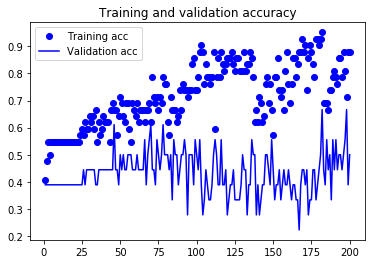

In [2431]:
'''
    Plotting accuracy VS epoch for training and validations
'''
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

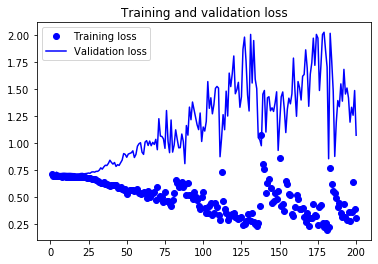

In [2432]:

'''
    Plotting loss VS epoch for training and validations
'''
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [130]:
'''
    Combining encoded tweets and embedding matrix into a single 3D array - tweet by words by embeddings. All of them are
    padded. We may have to later alter this as padding is not common in embeddings
'''
corpus = []
for tweet in vec_convert_quake_h:
    embed_tweet = []
    for word in tweet:
        embedding = word2vec_convert_quake_h[word]
        if embedding is not None:
            embed_tweet.append(embedding)
        else:
            embed_tweet.append(np.zeros(100))
    corpus.append(np.array(embed_tweet))
corpus = np.array(corpus)

'''
    We reshape the array 
'''
'''
corpus_reshape = []
for element in corpus:
    words, embeddings = element.shape
    reshape= element.reshape((words*embeddings))
    corpus_reshape.append(reshape)
    
corpus_reshape = np.array(corpus_reshape)
'''

tweets, words, embeddings = corpus.shape
corpus_reshape= corpus.reshape((tweets,words*embeddings))

In [131]:
alpha = np.linspace(0.001, 1, 500)

r = []
p = []
auc = []
acc = []
for j in alpha:
    X_train, X_val, Y_train, Y_val = train_test_split(corpus_reshape , t_quake_high, test_size=0.4, random_state=56)

    clf = SGDClassifier(loss = 'hinge', alpha = j, shuffle = True)
    clf.fit(X_train, Y_train)
    y_pred = clf.predict(X_val)
    '''
        Calibrating above model to yield probabilities. SGD with hinge loss does not spit out prob. It gives the value of 
        the decision function aka the value of the function across th hyperplane but that does not help us in this case. 
        Using loss as log or something else will give prob but we want to do SVM and not logistic regression. 
    '''
    model = CalibratedClassifierCV(clf)
    model.fit(X_train, Y_train)
    proba_cl = model.predict_proba(X_val)[:, 1]

    r.append(metrics.recall_score(Y_val, y_pred))
    p.append(metrics.precision_score(Y_val, y_pred))
    auc.append(roc_auc_score(Y_val, proba_cl))
    acc.append(metrics.accuracy_score(Y_val, y_pred))

C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warni

C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warni

C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warni

C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warni

C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warni

C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warni

C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warni

C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warni

C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warni

C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warni

C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warni

C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warni

C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warni

C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warni

C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warni

(0.0001, 1)

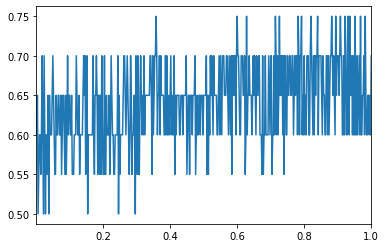

In [132]:
plt.plot(alpha, acc)
plt.xlim(0.0001, 1)

In [133]:
import statistics
'''
    We get the indices where acc is max..
'''
max_indices = [i for i in range(len(acc)) if acc[i] == max(acc)]
max_indices

[178,
 299,
 313,
 356,
 362,
 390,
 395,
 409,
 419,
 440,
 446,
 453,
 460,
 464,
 467,
 475,
 483,
 490]

In [136]:
print('Mean Accuracy = ', statistics.mean(acc[i] for i in max_indices))
print('Stdev Accuracy= ', statistics.stdev(acc[i] for i in max_indices))
print('Mean Precision = ', statistics.mean(p[i] for i in max_indices))
print('Stdev Precision= ', statistics.stdev(p[i] for i in max_indices))
print('Mean Recall = ', statistics.mean(r[i] for i in max_indices))
print('Stdev Recall = ', statistics.stdev(r[i] for i in max_indices))
print('Mean ROC AUC = ', statistics.mean(auc[i] for i in max_indices))
print('Stdev ROC AUC = ', statistics.stdev(auc[i] for i in max_indices)) 

Mean Accuracy =  0.75
Stdev Accuracy=  0.0
Mean Precision =  0.7592592592592593
Stdev Precision=  0.026948402781814786
Mean Recall =  0.654320987654321
Stdev Recall =  0.03593120370908635
Mean ROC AUC =  0.6941638608305275
Stdev ROC AUC =  0.04324608645203292


In [135]:
[alpha[i] for i in max_indices]

[0.3573567134268537,
 0.5995991983967937,
 0.6276272545090181,
 0.7137134268537074,
 0.7257254509018036,
 0.7817815631262526,
 0.7917915831663327,
 0.8198196392785572,
 0.8398396793587175,
 0.8818817635270542,
 0.8938937875751504,
 0.9079078156312625,
 0.9219218436873748,
 0.929929859719439,
 0.935935871743487,
 0.9519519038076153,
 0.9679679358717436,
 0.9819819639278557]

In [2473]:
coeff_collection = []
coeff = []
for i in range(1, len(clf.coef_[0])+1):
    if i%100 != 0:
        coeff.append(clf.coef_[0][i])
    else:
        coeff_collection.append(coeff)
        coeff = []
len(coeff_collection)

21

In [2477]:
coeff_avg = []
for element in coeff_collection:
    coeff_avg.append(np.mean(element))
coeff_avg

[-1.3710207723664327,
 1.403438633425413,
 -0.6649769908293485,
 1.6762594899817886,
 -0.9732650416183682,
 -1.3368054026783367,
 1.5181235815152176,
 0.7102491935770484,
 -0.7034787161696631,
 0.0177169559068757,
 0.44455089405148246,
 -0.43358379867401065,
 0.12266083693923478,
 -0.5103502300433801,
 -0.09930966731915307,
 2.125832957001501,
 -1.9839844267018667,
 1.600874386923185,
 -0.6830271944365233,
 0.0,
 0.0]

In [2445]:
flood_h_index

{'rt': 1,
 'bigwet': 2,
 'rescueph': 3,
 'flood': 4,
 'need': 5,
 'qpsmedia': 6,
 'road': 7,
 'st': 8,
 'alert': 9,
 'rescue': 10,
 'please': 11,
 'help': 12,
 'residents': 13,
 'weather': 14,
 'â€œ': 15,
 'marikina': 16,
 'river': 17,
 'amp': 18,
 'bundaberg': 19,
 'hwy': 20,
 'water': 21,
 'the': 22,
 'evacuate': 23,
 'no': 24,
 '2': 25,
 'tropical': 26,
 'level': 27,
 'areas': 28,
 'higher': 29,
 'grind': 30,
 'emergency': 31,
 'collapse': 32,
 'boulderflood': 33,
 'creek': 34,
 'flash': 35,
 'near': 36,
 'city': 37,
 'due': 38,
 'family': 39,
 'village': 40,
 '2nd': 41,
 'floor': 42,
 'move': 43,
 'queensland': 44,
 'warning': 45,
 'for': 46,
 'reports': 47,
 'â–¶': 48,
 'tornado': 49,
 'burnett': 50,
 'biloela': 51,
 'people': 52,
 'centre': 53,
 'hospital': 54,
 'qld': 55,
 'brisbane': 56,
 '1': 57,
 'hemamullur': 58,
 'two': 59,
 'truck': 60,
 'one': 61,
 'car': 62,
 '287': 63,
 'dillon': 64,
 'cowx': 65,
 'http': 66,
 'â€¦': 67,
 'coflood': 68,
 'bridge': 69,
 'roads': 70,
 'do